In [1]:

import pandas as pd

In [2]:
path_to_data = '/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/data/'

# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk(path_to_data):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))


# datasets with anomalies loading
datasets = [pd.read_csv(file,
                          sep=';',
                          index_col='datetime',
                          parse_dates=True) for file in all_files if 'other' not in file and 'anomaly-free' not in file]


# Concaténer les datasets en un seul DataFrame
data = pd.concat(datasets)


# Afficher le résultat
print(data)

                     Accelerometer1RMS  Accelerometer2RMS   Current  Pressure  \
datetime                                                                        
2020-03-09 13:54:39           0.028442           0.041158  0.402177  0.054711   
2020-03-09 13:54:40           0.027858           0.040170  0.622926  0.054711   
2020-03-09 13:54:41           0.027387           0.039822  0.428281 -0.273216   
2020-03-09 13:54:42           0.027286           0.039436  0.851965 -0.273216   
2020-03-09 13:54:43           0.027875           0.039764  0.714662  0.054711   
...                                ...                ...       ...       ...   
2020-03-09 16:36:26           0.026954           0.040592  1.200720  0.054711   
2020-03-09 16:36:27           0.027371           0.040530  1.318550 -0.273216   
2020-03-09 16:36:28           0.027557           0.039432  1.068740  0.054711   
2020-03-09 16:36:29           0.027456           0.038556  1.127880  0.054711   
2020-03-09 16:36:30         

In [3]:
print(data.columns)

Index(['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS',
       'anomaly', 'changepoint'],
      dtype='object')


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler

# Assurez-vous que vos données sont sous forme de float32
data = data.astype('float32')

# Division des données en ensembles d'entraînement et de test
train_data = data[:20000].drop(['anomaly', 'changepoint'], axis=1)
test_data = data[20000:].drop(['anomaly', 'changepoint'], axis=1)

# Normalisation des données avec Min-Max
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)


# Dimension de l'espace latent
input_dim = train_data.shape[1]
latent_dim = 3

# Encodeur
input_data = Input(shape=(input_dim,))
h = Dense(128, activation='relu')(input_data)
h = Dense(64, activation='relu')(h)
h = Dense(32, activation='relu')(h)
h = Dense(16, activation='relu')(h)
h = Dense(8, activation='relu')(h)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# Echantillonnage de l'espace latent
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Décodeur
decoder_h = Dense(8, activation='relu')
decoder_h1 = Dense(16, activation='relu')
decoder_h2 = Dense(32, activation='relu')
decoder_h3 = Dense(64, activation='relu')
decoder_h4 = Dense(128, activation='relu')
decoder_mean = Dense(input_dim, activation='linear')

h_decoded = decoder_h(z)
h_decoded = decoder_h1(h_decoded)
h_decoded = decoder_h2(h_decoded)
h_decoded = decoder_h3(h_decoded)
h_decoded = decoder_h4(h_decoded)
x_decoded_mean = decoder_mean(h_decoded)

# Construction du VAE
vae = Model(input_data, x_decoded_mean)

# Définition de la perte VAE = perte de reconstruction + KL divergence
reconstruction_loss = mse(input_data, x_decoded_mean)
reconstruction_loss *= input_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Early stopping (optionnel)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# TensorBoard callback pour la visualisation
tensorboard_callback = TensorBoard(log_dir='./logs')

# Entraînement du modèle
epochs = 300
batch_size = 100

history = vae.fit(train_data, train_data,
                  epochs=epochs,
                  batch_size=batch_size,
                  shuffle=True,
                  validation_data=(test_data, test_data),
                  callbacks=[early_stopping, tensorboard_callback])

# Définir l'encodeur
encoder = Model(input_data, z_mean)

# Définir le décodeur
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_h_decoded = decoder_h1(_h_decoded)
_h_decoded = decoder_h2(_h_decoded)
_h_decoded = decoder_h3(_h_decoded)
_h_decoded = decoder_h4(_h_decoded)
_x_decoded_mean = decoder_mean(_h_decoded)
decoder = Model(decoder_input, _x_decoded_mean)

import os
from tensorflow.keras.models import load_model

# Définir le répertoire de sauvegarde
save_dir = '/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Chemins complets pour sauvegarder les modèles
vae_path = os.path.join(save_dir, 'vae_model1.h5')
encoder_path = os.path.join(save_dir, 'encoder_model1.h5')
decoder_path = os.path.join(save_dir, 'decoder_model1.h5')

# Sauvegarder les modèles
vae.save(vae_path)
encoder.save(encoder_path)
decoder.save(decoder_path)

print(f"Les modèles ont été sauvegardés dans {save_dir}")


2024-08-14 22:20:42.529423: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-14 22:20:42.595061: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-14 22:20:42.596045: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-14 22:20:43.924026: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/300
200/200 [==============================] - 5s 8ms/step - loss: 0.3637 - val_loss: 0.2567
Epoch 2/300
200/200 [==============================] - 1s 5ms/step - loss: 0.2262 - val_loss: 0.2616
Epoch 3/300
200/200 [==============================] - 1s 5ms/step - loss: 0.2258 - val_loss: 0.2594
Epoch 4/300
200/200 [==============================] - 1s 5ms/step - loss: 0.2256 - val_loss: 0.2496
Epoch 5/300
200/200 [==============================] - 1s 6ms/step - loss: 0.2255 - val_loss: 0.2529
Epoch 6/300
200/200 [==============================] - 1s 5ms/step - loss: 0.2254 - val_loss: 0.2380
Epoch 7/300
200/200 [==============================] - 1s 5ms/step - loss: 0.2256 - val_loss: 0.2481
Epoch 8/300
200/200 [==============================] - 1s 6ms/step - loss: 0.2250 - val_loss: 0.2649
Epoch 9/300
200/200 [==============================] - 1s 5ms/step - loss: 0.2253 - val_loss: 0.2538
Epoch 10/300
200/200 [==============================] - 1s 5ms/step - loss: 0.2251 - val_lo

/home/manuemk/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Les modèles ont été sauvegardés dans /home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/


78/78 [==============================] - 0s 2ms/step


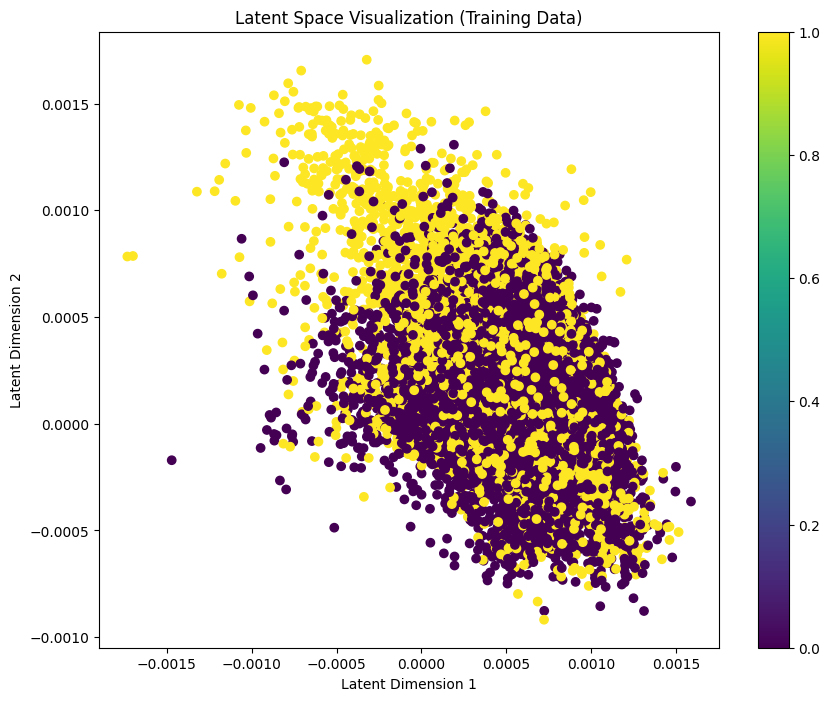

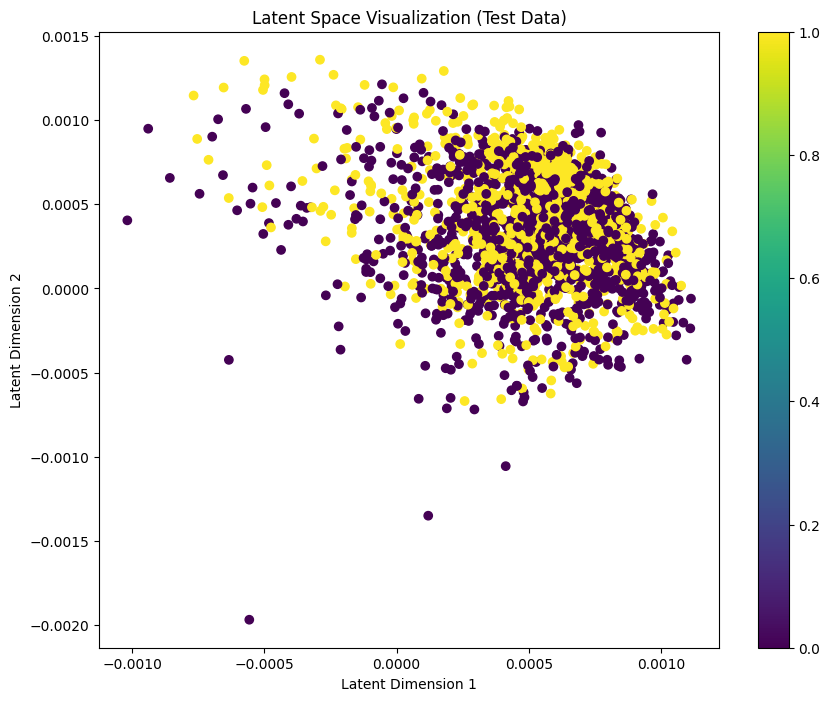

In [5]:
import matplotlib.pyplot as plt

# Encoder les données pour obtenir les vecteurs latents
encoder = Model(input_data, z_mean)
train_data_latent = encoder.predict(train_data)
test_data_latent = encoder.predict(test_data)

# Assumons que vous avez une colonne 'class' dans vos données d'origine pour les étiquettes de classe
train_labels = data[:20000]['anomaly']
test_labels = data[20000:]['anomaly']

# Visualisation des vecteurs latents en 2D
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_data_latent[:, 0], train_data_latent[:, 1], c=train_labels, cmap='viridis')
plt.colorbar(scatter)
plt.title('Latent Space Visualization (Training Data)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()

plt.figure(figsize=(10, 8))
scatter = plt.scatter(test_data_latent[:, 0], test_data_latent[:, 1], c=test_labels, cmap='viridis')
plt.colorbar(scatter)
plt.title('Latent Space Visualization (Test Data)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()


78/78 [==============================] - 0s 2ms/step
Class Prototypes in Latent Space:
Class 0.0: [ 0.00057801  0.00015148 -0.00085264]
Class 1.0: [ 0.00049735  0.00029047 -0.00057215]


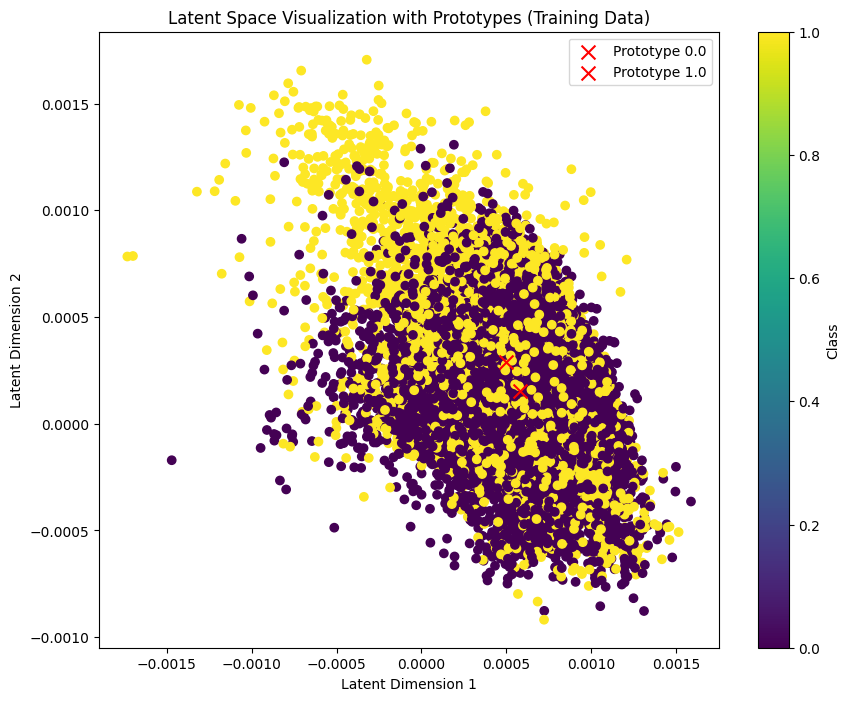

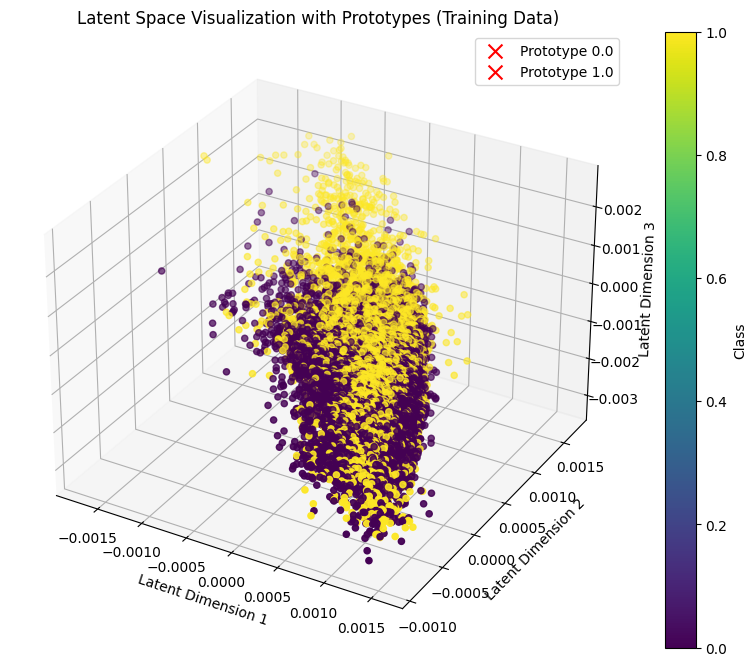

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Charger les modèles
vae = load_model('/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/vae_model1.h5', compile=False)
encoder = load_model('/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/encoder_model1.h5', compile=False)

# Encoder les données pour obtenir les vecteurs latents
train_data_latent = encoder.predict(train_data)
test_data_latent = encoder.predict(test_data)

# Assumons que vous avez une colonne 'class' dans vos données d'origine pour les étiquettes de classe
train_labels = data[:20000]['anomaly']
test_labels = data[20000:]['anomaly']

# Calculer les prototypes (centres de classe) dans l'espace latent
class_prototypes = {}
unique_classes = np.unique(train_labels)

for cls in unique_classes:
    class_latent_points = train_data_latent[train_labels == cls]
    class_prototypes[cls] = np.mean(class_latent_points, axis=0)

# Afficher les prototypes
print("Class Prototypes in Latent Space:")
for cls, prototype in class_prototypes.items():
    print(f"Class {cls}: {prototype}")

# Visualisation des prototypes en 2D (utiliser les deux premières dimensions latentes)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_data_latent[:, 0], train_data_latent[:, 1], c=train_labels, cmap='viridis')
plt.colorbar(scatter, label='Class')
for cls, prototype in class_prototypes.items():
    plt.scatter(prototype[0], prototype[1], c='red', marker='x', s=100, label=f'Prototype {cls}')
plt.legend()
plt.title('Latent Space Visualization with Prototypes (Training Data)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()

# Visualisation des prototypes en 3D (utiliser les trois premières dimensions latentes)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(train_data_latent[:, 0], train_data_latent[:, 1], train_data_latent[:, 2], c=train_labels, cmap='viridis')
fig.colorbar(scatter, label='Class')
for cls, prototype in class_prototypes.items():
    ax.scatter(prototype[0], prototype[1], prototype[2], c='red', marker='x', s=100, label=f'Prototype {cls}')
ax.set_title('Latent Space Visualization with Prototypes (Training Data)')
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
plt.legend()
plt.show()


In [7]:
path_to_data = '/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/data/other/'

# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk(path_to_data):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

# datasets with anomalies loading
list_of_df = [pd.read_csv(file,
                          sep=';',
                          index_col='datetime',
                          parse_dates=True) for file in all_files ]


# Concaténer les datasets en un seul DataFrame
test = pd.concat(list_of_df)


# Afficher le résultat
print(test)

                     Accelerometer1RMS  Accelerometer2RMS   Current  Pressure  \
datetime                                                                        
2020-02-08 18:10:42           0.240983           0.287449  2.879000  0.054711   
2020-02-08 18:10:43           0.241153           0.285669  2.696420  0.054711   
2020-02-08 18:10:44           0.246551           0.287455  2.582570  0.382638   
2020-02-08 18:10:45           0.238680           0.282037  2.207200  0.382638   
2020-02-08 18:10:46           0.238926           0.285487  0.936421  0.382638   
...                                ...                ...       ...       ...   
2020-03-01 15:57:02           0.080787           0.131610  1.527880 -0.273216   
2020-03-01 15:57:03           0.081003           0.128565  1.785830 -0.273216   
2020-03-01 15:57:04           0.079904           0.133247  1.510950 -0.273216   
2020-03-01 15:57:05           0.080195           0.130859  1.637560  0.054711   
2020-03-01 15:57:06         

In [8]:
#test_data = scaler.transform(test_data)
X = test.drop(['anomaly', 'changepoint'], axis=1)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
#X = scaler.transform(X)
y = test['anomaly']
z = test['changepoint']


y = y.astype(bool)
print(X)


[[0.318575   0.3464289  0.86133309 ... 0.82302399 0.71435202 0.95727564]
 [0.31881545 0.34416136 0.80371011 ... 0.82333117 0.35210797 0.96245094]
 [0.32645059 0.34643654 0.7677786  ... 0.82370855 0.50013923 0.95962668]
 ...
 [0.09073842 0.14999158 0.42957108 ... 0.01657861 0.60762619 0.55166465]
 [0.09115002 0.14694952 0.4695297  ... 0.01601692 0.50184714 0.55166465]
 [0.09203277 0.14347051 0.44934998 ... 0.01642941 0.45016429 0.55166465]]


In [9]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['font.size'] = 10

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mae
from tensorflow.keras.metrics import Mean
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [10]:
from tensorflow.keras.losses import mse

reconstructions = vae.predict(X, verbose=0)
reconstruction_error = mse(reconstructions, X)
print(reconstruction_error)

tf.Tensor([0.05633028 0.05110629 0.04751164 ... 0.041585   0.04190886 0.04532811], shape=(14929,), dtype=float64)


In [11]:
recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y
}).reset_index(drop=True)
recons_df1 = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y
}).reset_index(drop=True)
recons_df.head()

,error,y_true
0,0.056330,False
1,0.051106,False
2,0.047512,False
3,0.041037,False
4,0.047880,False


In [12]:
def thresholdTuning(df, iterations):

    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }

    for i in range(iterations):
        thresh_value = df['error'].quantile(i/iterations)
        preds = df['error'] > thresh_value
        cr = classification_report(df['y_true'], preds, output_dict=True)
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']

        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)

        print(f"Threshold: {thresh_value:.4f}\tAccuracy: {acc:.3f}\t\tPrecision: {prec:.3f}\tRecall Score: {rc:.3f}")

    return pd.DataFrame(thresh_df)

thresh_df = thresholdTuning(recons_df, 15)

Threshold: 0.0119	Accuracy: 0.351		Precision: 0.676	Recall Score: 0.500
Threshold: 0.0210	Accuracy: 0.402		Precision: 0.625	Recall Score: 0.534
Threshold: 0.0259	Accuracy: 0.453		Precision: 0.635	Recall Score: 0.569
Threshold: 0.0293	Accuracy: 0.504		Precision: 0.646	Recall Score: 0.602
Threshold: 0.0323	Accuracy: 0.547		Precision: 0.649	Recall Score: 0.628
Threshold: 0.0348	Accuracy: 0.589		Precision: 0.656	Recall Score: 0.652
Threshold: 0.0369	Accuracy: 0.613		Precision: 0.649	Recall Score: 0.657
Threshold: 0.0390	Accuracy: 0.632		Precision: 0.642	Recall Score: 0.655
Threshold: 0.0413	Accuracy: 0.652		Precision: 0.642	Recall Score: 0.655
Threshold: 0.0442	Accuracy: 0.667		Precision: 0.643	Recall Score: 0.651
Threshold: 0.0481	Accuracy: 0.689		Precision: 0.656	Recall Score: 0.652
Threshold: 0.0539	Accuracy: 0.705		Precision: 0.673	Recall Score: 0.649
Threshold: 0.0610	Accuracy: 0.716		Precision: 0.697	Recall Score: 0.639
Threshold: 0.0755	Accuracy: 0.721		Precision: 0.743	Recall Score

In [13]:
threshold = thresh_df[thresh_df['recall'] == thresh_df['recall'].max()]['threshold'].values[0]
print(f"Threshold with Maximum Recall: {threshold:.6f}")

Threshold with Maximum Recall: 0.036886


In [14]:
recons_df['y_pred'] = recons_df['error'] > threshold
recons_df

,error,y_true,y_pred
0,0.056330,False,True
1,0.051106,False,True
2,0.047512,False,True
3,0.041037,False,True
4,0.047880,False,True
...,...,...,...
14924,0.043456,True,True
14925,0.042381,True,True
14926,0.041585,True,True
14927,0.041909,True,True


In [15]:
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix

# Calculer la F1-score
f1 = f1_score(recons_df['y_true'], recons_df['y_pred'])
print(f'F1-score: {f1:.2f}')

# Calculer la matrice de confusion
tn, fn, fp, tp = confusion_matrix(recons_df['y_true'], recons_df['y_pred']).ravel()

# Calculer le taux de fausses alarmes (false alarm rate)
false_alarm_rate = fp / (fp + tn)
print(f'Taux de fausses alarmes: {false_alarm_rate:.2f}')

# Calculer le taux de manque d'alarmes (missing alarm rate)
missing_alarm_rate = fn / (fn + tp)
print(f'Taux de manque d\'alarmes: {missing_alarm_rate:.2f}')

F1-score: 0.59
Taux de fausses alarmes: 0.17
Taux de manque d'alarmes: 0.53


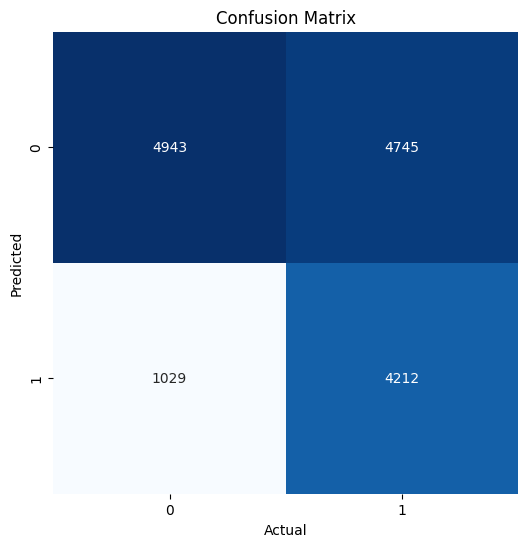

In [16]:
cm = confusion_matrix(recons_df['y_true'],recons_df['y_pred'])
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='.6g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

467/467 [==============================] - 1s 3ms/step
Threshold: 0.042281358650654334
Nombre d'anomalies détectées: 6569


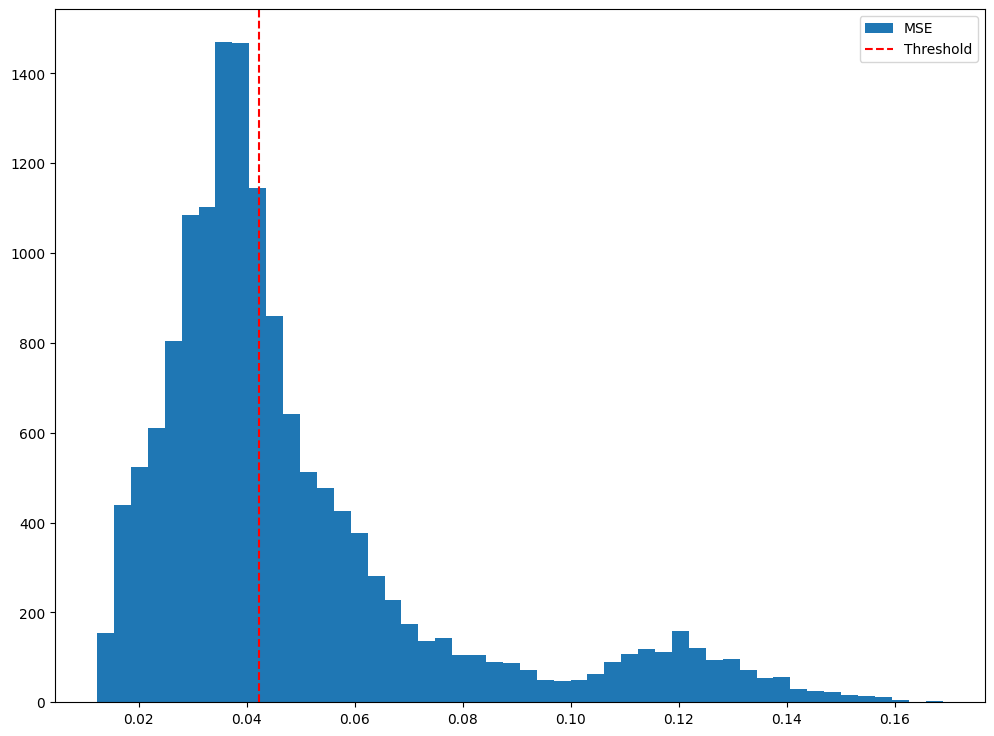

In [17]:
# Prédire les données de test et calculer l'erreur de reconstruction
X_test_pred = vae.predict(X)
mse = np.mean(np.power(X - X_test_pred, 2), axis=1)

# Déterminer un seuil pour les anomalies (ici, 95e percentile)
threshold1 = np.percentile(mse, 56)
print(f"Threshold: {threshold1}")

# Identifier les anomalies
anomalies = mse > threshold1
print(f"Nombre d'anomalies détectées: {np.sum(anomalies)}")

# Visualiser les anomalies détectées
plt.hist(mse, bins=50, label='MSE')
plt.axvline(threshold1, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.show()

In [18]:
recons_df1['y_pred'] = recons_df1['error'] > threshold1
recons_df1

,error,y_true,y_pred
0,0.056330,False,True
1,0.051106,False,True
2,0.047512,False,True
3,0.041037,False,False
4,0.047880,False,True
...,...,...,...
14924,0.043456,True,True
14925,0.042381,True,True
14926,0.041585,True,False
14927,0.041909,True,False


In [19]:
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix

# Calculer la F1-score
f1 = f1_score(recons_df1['y_true'], recons_df1['y_pred'])
print(f'F1-score: {f1:.2f}')

# Calculer la matrice de confusion
tn, fn, fp, tp = confusion_matrix(recons_df1['y_true'], recons_df1['y_pred']).ravel()

# Calculer le taux de fausses alarmes (false alarm rate)
false_alarm_rate = fp / (fp + tn)
print(f'Taux de fausses alarmes: {false_alarm_rate:.2f}')

# Calculer le taux de manque d'alarmes (missing alarm rate)
missing_alarm_rate = fn / (fn + tp)
print(f'Taux de manque d\'alarmes: {missing_alarm_rate:.2f}')

F1-score: 0.57
Taux de fausses alarmes: 0.22
Taux de manque d'alarmes: 0.49


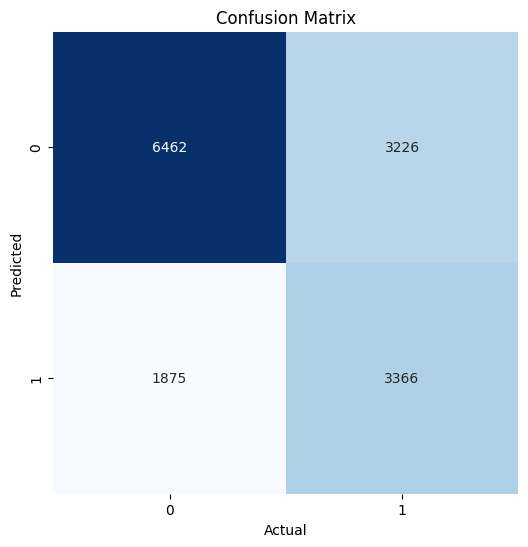

In [20]:
cm = confusion_matrix(recons_df1['y_true'],recons_df1['y_pred'])
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='.6g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [21]:
testt = X[3020:3070, :]
print(testt)
y_testt = y[3050:3080]
print(y)
print(z[3050:3080])

[[0.09226149 0.14454695 0.59376089 0.50000038 0.34063179 0.00801285
  0.63536117 0.57405288]
 [0.09165512 0.15201325 0.43665323 0.75       0.31687931 0.00741605
  0.65128929 0.56668728]
 [0.09195865 0.1520986  0.50944729 0.37500057 0.34382603 0.00753015
  0.98238253 0.56683526]
 [0.09276333 0.14394949 0.45305833 0.50000038 0.34832953 0.00727563
  0.6976442  0.57405288]
 [0.09142838 0.15242345 0.40513702 0.50000038 0.34137464 0.00752137
  0.41526352 0.56683526]
 [0.09232782 0.14455969 0.15703727 0.50000038 0.33835683 0.00732829
  0.30348822 0.5741986 ]
 [0.09229996 0.14989731 0.56056566 0.50000038 0.34212677 0.00732829
  0.52659328 0.5741986 ]
 [0.09210066 0.15219032 0.15286026 0.50000038 0.33279477 0.00834635
  0.53827018 0.5741986 ]
 [0.09305484 0.14303993 0.17165763 0.62500019 0.3409475  0.00667006
  0.36991108 0.5741986 ]
 [0.09142428 0.1530311  0.44170921 0.50000038 0.33851468 0.00761791
  0.07280896 0.57405288]
 [0.09228072 0.14646161 0.27105268 0.50000038 0.33559901 0.00659107
  

Data shape: (20000, 10)
Test data shape: (50, 8)
2/2 [==============================] - 0s 3ms/step
Initial Class Prototypes in Latent Space:
Class 0.0: [ 0.19596486 -0.4889308  -0.94250506]
Class 1.0: [ 0.20941782 -0.5075353  -0.98051965]
1/1 [==============================] - 0s 25ms/step
Updated Class 0.0 Prototype: [ 0.1958164  -0.48855907 -0.9417893 ]
Updated Class 1.0 Prototype: [ 0.20941782 -0.5075353  -0.98051965]
Detected anomalies: [0 1 2 3 4 5 6 7 8 9]
1/1 [==============================] - 0s 107ms/step
Updated Class 0.0 Prototype: [ 0.19566815 -0.48818788 -0.94107467]
Updated Class 1.0 Prototype: [ 0.20941782 -0.5075353  -0.98051965]
Detected anomalies: [0 1 2 3 4 5 6 7 8 9]
1/1 [==============================] - 0s 24ms/step
Updated Class 0.0 Prototype: [ 0.19552009 -0.48781732 -0.94036114]
Updated Class 1.0 Prototype: [ 0.20941782 -0.5075353  -0.98051965]
Detected anomalies: [0 1 2 3 4 5 6 7 8 9]
No data points processed in this window.
No data points processed in this w

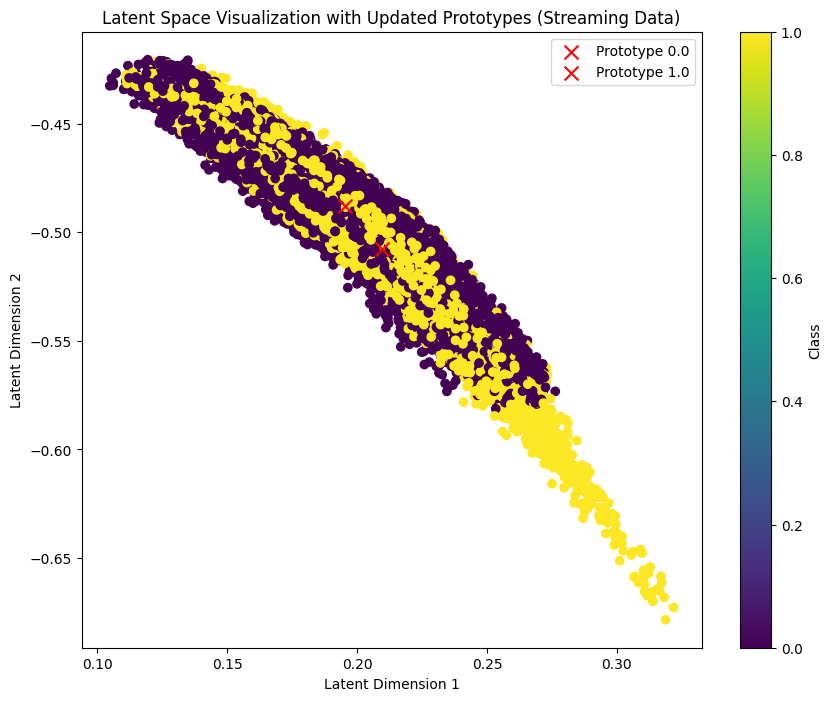

In [22]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances

# Charger les modèles
vae = load_model('/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/vae_model1.h5', compile=False)
encoder = load_model('/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/encoder_model1.h5', compile=False)

# Supposons que vous avez déjà les données d'entraînement et de test
# Par exemple :
# data = pd.read_csv('train_data.csv')
# testt = pd.read_csv('test_data.csv')
# y_testt = pd.read_csv('y_test.csv')

# Assurez-vous que ces données existent
assert 'data' in globals(), "Les données d'entraînement 'data' ne sont pas définies"
assert 'testt' in globals(), "Les données de test 'testt' ne sont pas définies"
assert 'y_testt' in globals(), "Les étiquettes de test 'y_testt' ne sont pas définies"

# Assumons que vous avez une colonne 'anomaly' dans vos données d'origine pour les étiquettes de classe
train_data_labels = data[:20000][['anomaly']]
test_data_labels = y_testt

print(f"Data shape: {data[:20000].shape}")
print(f"Test data shape: {testt.shape}")

# Encoder les données initiales pour obtenir les vecteurs latents
train_data_latent = encoder.predict(data[:20000].drop(['anomaly', 'changepoint'], axis=1))
test_data_latent = encoder.predict(testt)

# Initialiser les prototypes (centres de classe) dans l'espace latent
class_prototypes = {}
class_counts = {}
unique_classes = np.unique(train_data_labels)

for cls in unique_classes:
    class_latent_points = train_data_latent[train_data_labels['anomaly'] == cls].reshape(-1, train_data_latent.shape[-1])
    class_prototypes[cls] = np.mean(class_latent_points, axis=0)
    class_counts[cls] = class_latent_points.shape[0]

# Afficher les prototypes initiaux
print("Initial Class Prototypes in Latent Space:")
for cls, prototype in class_prototypes.items():
    print(f"Class {cls}: {prototype}")

# Fonction pour mettre à jour les prototypes
def update_prototype(current_prototype, new_points, count):
    new_points_mean = np.mean(new_points, axis=0)
    new_count = new_points.shape[0]
    return (current_prototype * count + new_points_mean * new_count) / (count + new_count)

# Fonction pour détecter les anomalies
def detect_anomalies(latent_points, prototypes, threshold):
    distances = np.min(euclidean_distances(latent_points, np.vstack(list(prototypes.values()))), axis=1)
    return distances > threshold

# Initialiser les tampons pour chaque classe
buffers = defaultdict(list)
window_size = 10  # Taille de la fenêtre (nombre de points)
anomaly_threshold = threshold  # Exemple de seuil pour la détection d'anomalies

# Fonction pour traiter les données de flux avec mise à jour après chaque fenêtre
def process_streaming_data(new_data_points, new_data_labels):
    latent_points = []
    labels = []
    for new_data_point, new_data_label in zip(new_data_points, new_data_labels):
        # Encoder le nouveau point de données
        new_data_latent = encoder.predict(np.array([new_data_point]))
        new_data_latent = new_data_latent.reshape(-1)  # Redimensionner pour correspondre

        # Ajouter le point latent au tampon correspondant à sa classe
        buffers[new_data_label].append(new_data_latent)
        latent_points.append(new_data_latent)
        labels.append(new_data_label)

        # Si le tampon atteint la taille de la fenêtre, mettre à jour le prototype
        if len(buffers[new_data_label]) >= window_size:
            class_prototypes[new_data_label] = update_prototype(
                class_prototypes[new_data_label],
                np.vstack(buffers[new_data_label]),  # Convertir la liste en tableau NumPy
                class_counts[new_data_label]
            )
            class_counts[new_data_label] += len(buffers[new_data_label])
            buffers[new_data_label] = []  # Réinitialiser le tampon

    # Convertir en tableau NumPy
    if latent_points:
        latent_points = np.array(latent_points)
        labels = np.array(labels)

        # Détecter les anomalies
        anomalies = detect_anomalies(latent_points, class_prototypes, anomaly_threshold)

        # Afficher les prototypes mis à jour et les anomalies détectées
        for cls, prototype in class_prototypes.items():
            print(f"Updated Class {cls} Prototype: {prototype}")
        print("Detected anomalies:", np.where(anomalies)[0])
    else:
        print("No data points processed in this window.")

# Exemple de traitement de nouvelles données en flux
for i in range(0, len(testt), window_size):
    new_data_points = testt[i:i+window_size]
    new_data_labels = y_testt[i:i+window_size]
    process_streaming_data(new_data_points, new_data_labels)

# Visualisation des prototypes mis à jour en 2D
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_data_latent[:, 0], train_data_latent[:, 1], c=train_data_labels['anomaly'], cmap='viridis')
plt.colorbar(scatter, label='Class')
for cls, prototype in class_prototypes.items():
    plt.scatter(prototype[0], prototype[1], c='red', marker='x', s=100, label=f'Prototype {cls}')
plt.legend()
plt.title('Latent Space Visualization with Updated Prototypes (Streaming Data)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()


Data shape: (20000, 10)
Test data shape: (50, 8)
2/2 [==============================] - 0s 3ms/step
Initial Class Prototypes in Latent Space:
Class 0.0: [ 0.19596486 -0.4889308  -0.94250506]
Class 1.0: [ 0.20941782 -0.5075353  -0.98051965]
1/1 [==============================] - 0s 26ms/step
Updated and Reconstructed Class 0.0 Prototype: [[0.31223786 0.24370801 0.46102056 0.44914764 0.33511478 0.41298988
  0.5401852  0.77129614]]
Updated and Reconstructed Class 1.0 Prototype: [[0.31221682 0.24371026 0.46092683 0.4490168  0.33510223 0.41271767
  0.54029924 0.7713677 ]]
Detected anomalies: [0 1 2 3 4 5 6 7 8 9]
1/1 [==============================] - 0s 37ms/step
Updated and Reconstructed Class 0.0 Prototype: [[0.31223798 0.24370968 0.46102363 0.44914976 0.33511615 0.4129957
  0.5401835  0.77129614]]
Updated and Reconstructed Class 1.0 Prototype: [[0.31221682 0.24371026 0.46092683 0.4490168  0.33510223 0.41271767
  0.54029924 0.7713677 ]]
Detected anomalies: [0 1 2 3 4 5 6 7 8 9]
1/1 [====

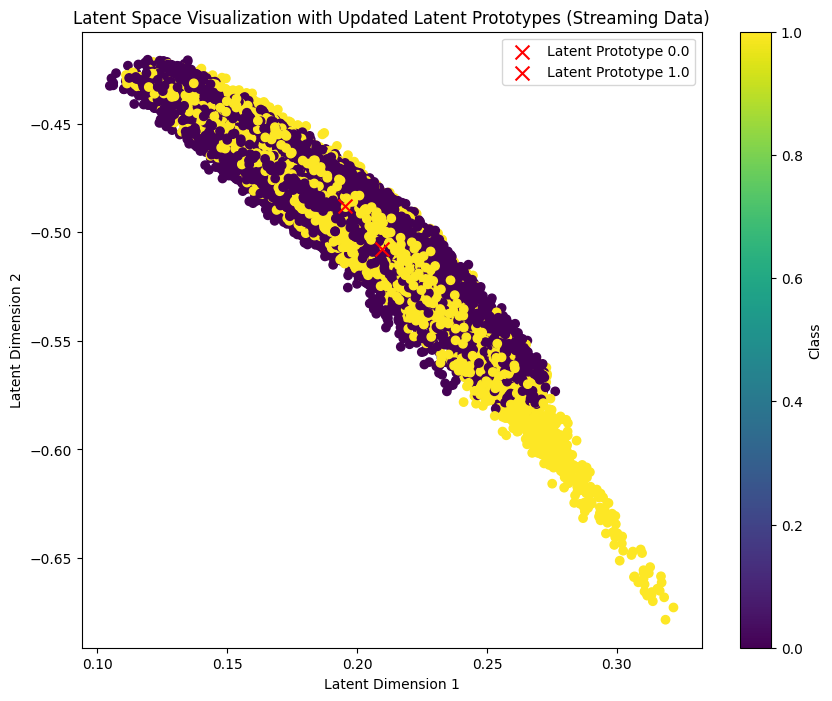

In [23]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances

# Charger les modèles
vae = load_model('/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/vae_model1.h5', compile=False)
encoder = load_model('/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/encoder_model1.h5', compile=False)
decoder = load_model('/home/manuemk/Documents/M2/RECHERCHES/CODES/SKAB-master/models/decoder_model1.h5', compile=False)

# Supposons que vous avez déjà les données d'entraînement et de test
# Par exemple :
# data = pd.read_csv('train_data.csv')
# testt = pd.read_csv('test_data.csv')
# y_testt = pd.read_csv('y_test.csv')

# Assurez-vous que ces données existent
assert 'data' in globals(), "Les données d'entraînement 'data' ne sont pas définies"
assert 'testt' in globals(), "Les données de test 'testt' ne sont pas définies"
assert 'y_testt' in globals(), "Les étiquettes de test 'y_testt' ne sont pas définies"

# Assumons que vous avez une colonne 'anomaly' dans vos données d'origine pour les étiquettes de classe
train_data_labels = data[:20000][['anomaly']]
test_data_labels = y_testt

print(f"Data shape: {data[:20000].shape}")
print(f"Test data shape: {testt.shape}")

# Encoder les données initiales pour obtenir les vecteurs latents
train_data_latent = encoder.predict(data[:20000].drop(['anomaly', 'changepoint'], axis=1))
test_data_latent = encoder.predict(testt)

# Initialiser les prototypes (centres de classe) dans l'espace latent
class_prototypes = {}
class_counts = {}
unique_classes = np.unique(train_data_labels)

class_latent_points_dict = defaultdict(list)
for cls in unique_classes:
    class_latent_points = train_data_latent[train_data_labels['anomaly'] == cls].reshape(-1, train_data_latent.shape[-1])
    class_latent_points_dict[cls] = list(class_latent_points)
    class_prototypes[cls] = np.mean(class_latent_points, axis=0)
    class_counts[cls] = class_latent_points.shape[0]

# Afficher les prototypes initiaux
print("Initial Class Prototypes in Latent Space:")
for cls, prototype in class_prototypes.items():
    print(f"Class {cls}: {prototype}")

# Fonction pour mettre à jour les prototypes en utilisant tous les points disponibles
def update_prototypes():
    for cls in unique_classes:
        if class_latent_points_dict[cls]:
            class_prototypes[cls] = np.mean(class_latent_points_dict[cls], axis=0)

# Fonction pour détecter les anomalies
def detect_anomalies(latent_points, prototypes, threshold):
    distances = np.min(euclidean_distances(latent_points, np.vstack(list(prototypes.values()))), axis=1)
    return distances > threshold

# Initialiser les tampons pour chaque classe
buffers = defaultdict(list)
window_size = 10  # Taille de la fenêtre (nombre de points)
anomaly_threshold = 0.5  # Exemple de seuil pour la détection d'anomalies

# Fonction pour traiter les données de flux avec mise à jour après chaque fenêtre
def process_streaming_data(new_data_points, new_data_labels):
    latent_points = []
    labels = []
    for new_data_point, new_data_label in zip(new_data_points, new_data_labels):
        # Encoder le nouveau point de données
        new_data_latent = encoder.predict(np.array([new_data_point]))
        new_data_latent = new_data_latent.reshape(-1)  # Redimensionner pour correspondre

        # Ajouter le point latent à la liste complète pour sa classe
        class_latent_points_dict[new_data_label].append(new_data_latent)
        latent_points.append(new_data_latent)
        labels.append(new_data_label)

    # Mettre à jour les prototypes après chaque fenêtre
    update_prototypes()

    # Convertir en tableau NumPy
    if latent_points:
        latent_points = np.array(latent_points)
        labels = np.array(labels)

        # Détecter les anomalies
        anomalies = detect_anomalies(latent_points, class_prototypes, anomaly_threshold)

        # Reconstruire les prototypes
        reconstructed_prototypes = {}
        for cls, prototype in class_prototypes.items():
            reconstructed_prototypes[cls] = decoder.predict(np.array([prototype]))

        # Afficher les prototypes reconstruits et les anomalies détectées
        for cls, prototype in reconstructed_prototypes.items():
            print(f"Updated and Reconstructed Class {cls} Prototype: {prototype}")
        print("Detected anomalies:", np.where(anomalies)[0])
    else:
        print("No data points processed in this window.")

# Exemple de traitement de nouvelles données en flux
for i in range(0, len(testt), window_size):
    new_data_points = testt[i:i+window_size]
    new_data_labels = y_testt[i:i+window_size]
    process_streaming_data(new_data_points, new_data_labels)

# Visualisation des prototypes latents en 2D
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_data_latent[:, 0], train_data_latent[:, 1], c=train_data_labels['anomaly'], cmap='viridis')
plt.colorbar(scatter, label='Class')
for cls, prototype in class_prototypes.items():
    plt.scatter(prototype[0], prototype[1], c='red', marker='x', s=100, label=f'Latent Prototype {cls}')
plt.legend()
plt.title('Latent Space Visualization with Updated Latent Prototypes (Streaming Data)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()


In [24]:
y.iloc[4070:4080]

datetime
2020-02-08 16:23:26    True
2020-02-08 16:23:27    True
2020-02-08 16:23:29    True
2020-02-08 16:23:30    True
2020-02-08 16:23:31    True
2020-02-08 16:23:32    True
2020-02-08 16:23:33    True
2020-02-08 16:23:34    True
2020-02-08 16:23:35    True
2020-02-08 16:23:36    True
Name: anomaly, dtype: bool

In [25]:
import tensorflow as tf
import numpy as np

def arcana_proto(x, x_prot, ae_model, alpha=0.8):
    """
    Implement the ARCANA algorithm to find the features that contributed to an anomaly.

    Args:
        x (np.ndarray): The input feature vector.
        ae_model (tf.keras.Model): The trained autoencoder model.
        alpha (float): Hyperparameter controlling the trade-off between reconstruction error and sparsity of the bias vector.

    Returns:
        x_bias (np.ndarray): The bias vector representing the deviation of each feature causing the anomaly.
        feature_importances (np.ndarray): The normalized absolute values of the bias vector, representing the feature importances.
    """
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    x = tf.expand_dims(x, axis=0)

    with tf.GradientTape() as tape:
        x_corrected = x + tf.Variable(tf.zeros_like(x), name='x_bias', dtype=tf.float32)
        reconstruction = ae_model(x_corrected)[0]

        # Calculate the loss function
        loss_reconstruction = tf.reduce_mean(tf.square(x_prot - reconstruction))
        loss_sparsity = tf.reduce_mean(tf.abs(x_prot - x))
        loss = (1 - alpha) * loss_reconstruction + alpha * loss_sparsity

    # Calculate the gradients of the loss function with respect to the bias vector
    gradients = tape.gradient(loss, x_corrected)

    # Update the bias vector using the gradients
    x_bias = -gradients.numpy()[0]
    feature_importances = tf.math.l2_normalize(tf.abs(x_bias), axis=0).numpy()

    return x_bias, feature_importances

# Assuming you have a trained autoencoder model and a sample input feature vector



In [26]:
prototype_sequences = [0.32039854, 0.26242667, 0.4764632,  0.45544222, 0.328977,   0.43214652,
  0.52930045, 0.77412677]
prototype_sequences

[0.32039854,
 0.26242667,
 0.4764632,
 0.45544222,
 0.328977,
 0.43214652,
 0.52930045,
 0.77412677]

In [27]:
# Définir une variable globale pour stocker les biais
x_biases = []
feature_importances_proto = []


x = X[4070, :]
#x = x # Your input feature vector
ae_model = vae # Your trained autoencoder model

#for i in range(3):
x_bias, feature_importance = arcana_proto(x, prototype_sequences, ae_model, alpha=0.8)
x_biases.append(x_bias)
feature_importances_proto.append(feature_importance)

print("Bias vector:", x_biases)
print("Feature importances:", feature_importances_proto)

Bias vector: [array([-1.1806824e-07, -5.5400474e-08,  6.2438531e-08,  2.1358289e-08,
        1.5481902e-07, -6.9807115e-08,  5.5832384e-08, -6.4802457e-09],
      dtype=float32)]
Feature importances: [array([0.11806824, 0.05540047, 0.06243853, 0.02135829, 0.15481903,
       0.06980711, 0.05583238, 0.00648025], dtype=float32)]


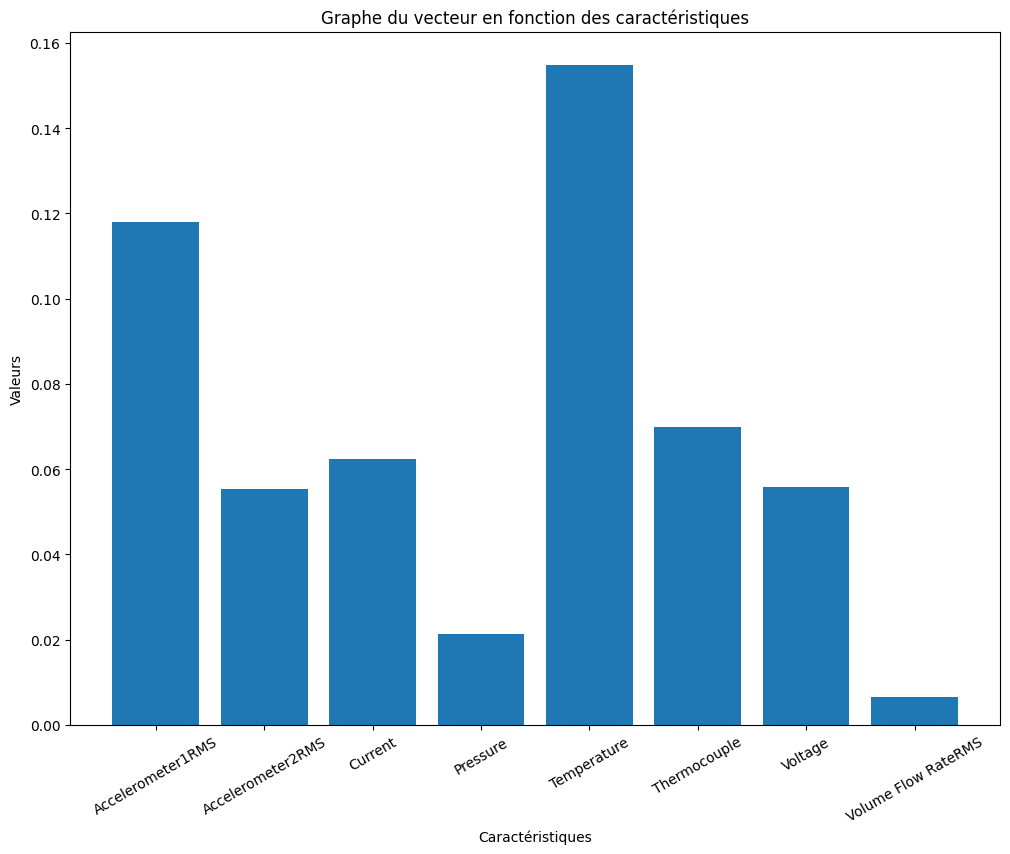

In [28]:
import matplotlib.pyplot as plt
import numpy as np


#for i in range(len(feature_importances)):
# Vecteur de valeurs
vector = feature_importances_proto[0]  # Assuming vector represents a single feature

# Noms des caractéristiques
features = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']

# Tracer le graphe à barres
plt.bar(features, vector)
plt.xlabel('Caractéristiques')
plt.ylabel('Valeurs')
plt.title('Graphe du vecteur en fonction des caractéristiques')
plt.xticks(rotation=30)
plt.show()

In [29]:
print(x)

import numpy as np
from sklearn.metrics import mean_squared_error

# Données d'entrée
input_data = x

# Mise en forme des données pour l'autoencoder
input_data = np.expand_dims(input_data, axis=0)  # Ajouter une dimension de batch

# Prédictions de l'autoencoder
reconstructions = vae.predict(input_data)

# Calcul de l'erreur de reconstruction
reconstruction_error = mean_squared_error(input_data.flatten(), reconstructions.flatten())

# Définir un seuil pour la détection d'anomalies
#threshold = 0.5  # Vous pouvez ajuster ce seuil en fonction de vos besoins

# Détection des anomalies
pred = reconstruction_error > threshold

print("Erreur de reconstruction:", reconstruction_error)
print("Anomalie détectée:", pred)


[0.87014333 0.90028833 0.59195563 0.62500019 0.36109718 0.65709747
 0.58494069 0.93744577]
1/1 [==============================] - 0s 272ms/step
Erreur de reconstruction: 0.11108831436404674
Anomalie détectée: True


In [30]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Données d'entrée
input_data = np.array([0, 0, 0.59195563, 0.62500019, 0.36109718, 0,
 0, 0.93744577])
#labels = np.array([64])

# Mise en forme des données pour l'autoencoder
input_data = np.expand_dims(input_data, axis=0)  # Ajouter une dimension de batch

# Prédictions de l'autoencoder
reconstructions = vae.predict(input_data)

# Calcul de l'erreur de reconstruction
reconstruction_error = mean_squared_error(input_data.flatten(), reconstructions.flatten())

# Définir un seuil pour la détection d'anomalies
#threshold = 0.5  # Vous pouvez ajuster ce seuil en fonction de vos besoins

# Détection des anomalies
pred = reconstruction_error > threshold

print("Erreur de reconstruction:", reconstruction_error)
print("Anomalie détectée:", pred)


1/1 [==============================] - 0s 58ms/step
Erreur de reconstruction: 0.08710660226698438
Anomalie détectée: True


In [31]:
import tensorflow as tf
import numpy as np

def arcana(x, ae_model, alpha=0.8):
    """
    Implement the ARCANA algorithm to find the features that contributed to an anomaly.

    Args:
        x (np.ndarray): The input feature vector.
        ae_model (tf.keras.Model): The trained autoencoder model.
        alpha (float): Hyperparameter controlling the trade-off between reconstruction error and sparsity of the bias vector.

    Returns:
        x_bias (np.ndarray): The bias vector representing the deviation of each feature causing the anomaly.
        feature_importances (np.ndarray): The normalized absolute values of the bias vector, representing the feature importances.
    """
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    x = tf.expand_dims(x, axis=0)

    with tf.GradientTape() as tape:
        x_corrected = x + tf.Variable(tf.zeros_like(x), name='x_bias', dtype=tf.float32)
        reconstruction = ae_model(x_corrected)[0]

        # Calculate the loss function
        loss_reconstruction = tf.reduce_mean(tf.square(x_corrected - reconstruction))
        loss_sparsity = tf.reduce_mean(tf.abs(x_corrected - x))
        loss = (1 - alpha) * loss_reconstruction + alpha * loss_sparsity

    # Calculate the gradients of the loss function with respect to the bias vector
    gradients = tape.gradient(loss, x_corrected)

    # Update the bias vector using the gradients
    x_bias = -gradients.numpy()[0]
    feature_importances = tf.math.l2_normalize(tf.abs(x_bias), axis=0).numpy()

    return x_bias, feature_importances

# Assuming you have a trained autoencoder model and a sample input feature vector



In [32]:
# Définir une variable globale pour stocker les biais
x_biases = []
feature_importances = []


x = X[4079, :]
#x = x # Your input feature vector
ae_model = vae # Your trained autoencoder model

#for i in range(3):
x_bias, feature_importance = arcana(x, ae_model, alpha=0.8)
x_biases.append(x_bias)
feature_importances.append(feature_importance)

print("Bias vector:", x_biases)
print("Feature importances:", feature_importances)

Bias vector: [array([-0.02770312, -0.03256214, -0.01292717, -0.00232304, -0.00171331,
       -0.0122376 ,  0.0004381 , -0.00747555], dtype=float32)]
Feature importances: [array([0.5894236 , 0.69280607, 0.27504408, 0.04942598, 0.03645322,
       0.26037258, 0.0093211 , 0.15905295], dtype=float32)]


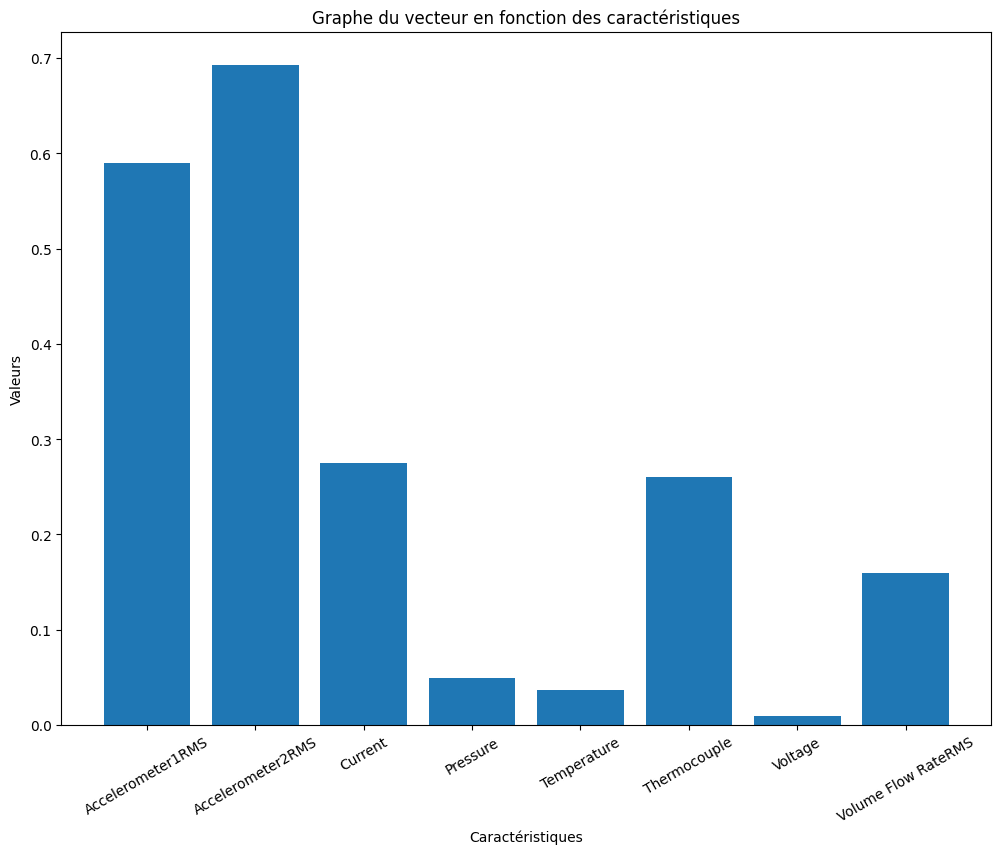

In [33]:
import matplotlib.pyplot as plt
import numpy as np


#for i in range(len(feature_importances)):
# Vecteur de valeurs
vector = feature_importances[0]  # Assuming vector represents a single feature

# Noms des caractéristiques
features = ['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']

# Tracer le graphe à barres
plt.bar(features, vector)
plt.xlabel('Caractéristiques')
plt.ylabel('Valeurs')
plt.title('Graphe du vecteur en fonction des caractéristiques')
plt.xticks(rotation=30)
plt.show()

In [34]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Données d'entrée
input_data = np.array([0, 0, 0.59195563, 0.62500019, 0.36109718, 0.65709747,
 0.58494069, 0.93744577])
#labels = np.array([64])

# Mise en forme des données pour l'autoencoder
input_data = np.expand_dims(input_data, axis=0)  # Ajouter une dimension de batch

# Prédictions de l'autoencoder
reconstructions = vae.predict(input_data)

# Calcul de l'erreur de reconstruction
reconstruction_error = mean_squared_error(input_data.flatten(), reconstructions.flatten())

# Définir un seuil pour la détection d'anomalies
#threshold = 0.5  # Vous pouvez ajuster ce seuil en fonction de vos besoins

# Détection des anomalies
pred = reconstruction_error > threshold

print("Erreur de reconstruction:", reconstruction_error)
print("Anomalie détectée:", pred)


1/1 [==============================] - 0s 23ms/step
Erreur de reconstruction: 0.03709805056281462
Anomalie détectée: True
